# Assignment 6 - Group Assignment 1

## A bit of info before you start.


> ***First and foremost, dont use AI to code. Use it to understand and then write code yourself. Use AI to verify if the code you wrote it correct, that will help you learn far far more.***

> ***Use cv2 functions only or atleast wherever possible.***

> **This assignment marks 1/3rd of your project. And hence, it is the first part of the final submission from your team.**







## Create a DataLoader Class

Use the pytorch docs sent on group and deepen your understanding using sample practice, or even AI.

Finally, create a dataloader for the Fruits-360 dataset ( https://www.kaggle.com/datasets/moltean/fruits ).
In <code>__getitem__</code> , include the processing to create LBP image, canny image, and find the 6 color features and 6 shape features.
Best implementation should include a proper division of tasks between the method itself and utility functions.
Also brainstorm about the data structures you use to process and pass the info. Use cv2 functions for best performance.

In [59]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fruits' dataset.
Path to dataset files: /kaggle/input/fruits


In [60]:
# Importing libraries

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

In [61]:
IMG_SIZE = 100
CANNY_LOW = 100
CANNY_HIGH = 200

In [62]:
path = os.path.join(path, "fruits-360_100x100", "fruits-360")

os.listdir(path)
training = os.path.join(path, "Training")
test = os.path.join(path, "Test")

In [63]:
def compute_lbp(gray):

    # Computes Local Binary Pattern image from grayscale input

    h, w = gray.shape
    lbp = np.zeros((h, w), dtype=np.uint8)

    for i in range(1, h - 1):
        for j in range(1, w - 1):
            center = gray[i, j]
            code = 0

            code |= (gray[i-1, j-1] >= center) << 7
            code |= (gray[i-1, j  ] >= center) << 6
            code |= (gray[i-1, j+1] >= center) << 5
            code |= (gray[i  , j+1] >= center) << 4
            code |= (gray[i+1, j+1] >= center) << 3
            code |= (gray[i+1, j  ] >= center) << 2
            code |= (gray[i+1, j-1] >= center) << 1
            code |= (gray[i  , j-1] >= center) << 0

            lbp[i, j] = code

    return lbp.astype(np.float32) / 255.0


In [64]:
def extract_color_features(rgb):

    # Extracts 6 HSV color features

    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)

    # Mask low-saturation (background)
    mask = s > 0.1

    if np.sum(mask) == 0:
        return np.zeros(6, dtype=np.float32)

    return np.array([
        np.mean(h[mask]), np.std(h[mask]),
        np.mean(s[mask]), np.std(s[mask]),
        np.mean(v[mask]), np.std(v[mask])
    ], dtype=np.float32)

In [65]:
def compute_canny(gray):

    # Computes Canny edge map

    return cv2.Canny(gray, CANNY_LOW, CANNY_HIGH)


In [66]:
def extract_shape_features(gray):
    _, mask = cv2.threshold(gray, 245, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    if not contours:
        return np.zeros(6, dtype=np.float32)

    cnt = max(contours, key=cv2.contourArea)

    # Area-based features
    area = cv2.contourArea(cnt)
    img_area = gray.shape[0] * gray.shape[1]
    area_ratio = area / img_area

    # Bounding box aspect ratio
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / h if h > 0 else 0

    # Perimeter & circularity
    perimeter = cv2.arcLength(cnt, True)
    circularity = 4 * np.pi * area / (perimeter**2 + 1e-10)

    # Hu moments
    moments = cv2.moments(cnt)
    hu = cv2.HuMoments(moments).flatten()

    hu1 = -np.sign(hu[0]) * np.log10(abs(hu[0]) + 1e-10)
    hu2 = -np.sign(hu[1]) * np.log10(abs(hu[1]) + 1e-10)

    return np.array([
        area_ratio,
        aspect_ratio,
        perimeter,
        circularity,
        hu1,
        hu2
    ])


In [67]:
def visualize_sample(img_path):
    img = cv2.imread(img_path)
    assert img is not None, f"Failed to load {img_path}"

    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

    lbp = compute_lbp(gray)
    canny = compute_canny(gray)

    #HSV-based foreground mask
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    _, s, _ = cv2.split(hsv)

    mask = (s > 20).astype("uint8") * 255

    # Clean mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    contour_img = rgb.copy()
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        cv2.drawContours(contour_img, [cnt], -1, (255, 0, 0), 2)

    # Visualization
    plt.figure(figsize=(15, 8))

    plt.subplot(2, 3, 1)
    plt.imshow(rgb)
    plt.title("RGB")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(lbp, cmap="gray")
    plt.title("LBP")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(canny, cmap="gray")
    plt.title("Canny")
    plt.axis("off")

    plt.subplot(2, 3, 4)
    plt.imshow(mask, cmap="gray")
    plt.title("HSV Saturation Mask")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(contour_img)
    plt.title("Contour Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [68]:
class Fruits360Dataset(Dataset):
    """
    PyTorch Dataset for Fruits-360.
    Returns RGB image, LBP image, Canny edge map, and label.
    """

    def __init__(self, root_dir):
        self.samples = []

        class_names = sorted(os.listdir(root_dir))
        for class_id, class_name in enumerate(class_names):
            class_path = os.path.join(root_dir, class_name)

            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.samples.append((img_path, class_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        img_path, label = self.samples[index]

        # Load image
        bgr = cv2.imread(img_path)
        assert bgr is not None, f"Failed to load {img_path}"

        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

        # Feature maps
        lbp = compute_lbp(gray)          # already normalized
        canny = compute_canny(gray)      # uint8

        # Normalize RGB
        rgb = rgb.astype(np.float32) / 255.0
        canny = canny.astype(np.float32) / 255.0

        # Convert to tensors
        rgb = torch.tensor(rgb, dtype=torch.float32).permute(2, 0, 1)
        lbp = torch.tensor(lbp, dtype=torch.float32).unsqueeze(0)
        canny = torch.tensor(canny, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.long)

        return rgb, lbp, canny, label

In [69]:
train_dataset = Fruits360Dataset(training)
test_dataset  = Fruits360Dataset(test)

In [70]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [71]:
def print_linear_features(img_path):
    """
    Loads an image and prints extracted linear features
    (color + shape).
    """

    img = cv2.imread(img_path)
    assert img is not None, f"Failed to load {img_path}"

    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    color_feat = extract_color_features(rgb)
    shape_feat = extract_shape_features(gray)

    features = np.concatenate([color_feat, shape_feat])

    feature_names = [
        "H_mean", "H_std", "S_mean", "S_std", "V_mean", "V_std",
        "Area_ratio", "Aspect_ratio", "Perimeter_norm",
        "Circularity", "Hu1", "Hu2"
    ]

    df = pd.DataFrame([features], columns=feature_names)

    print("Linear features for:", img_path)
    display(df)

    return color_feat, shape_feat


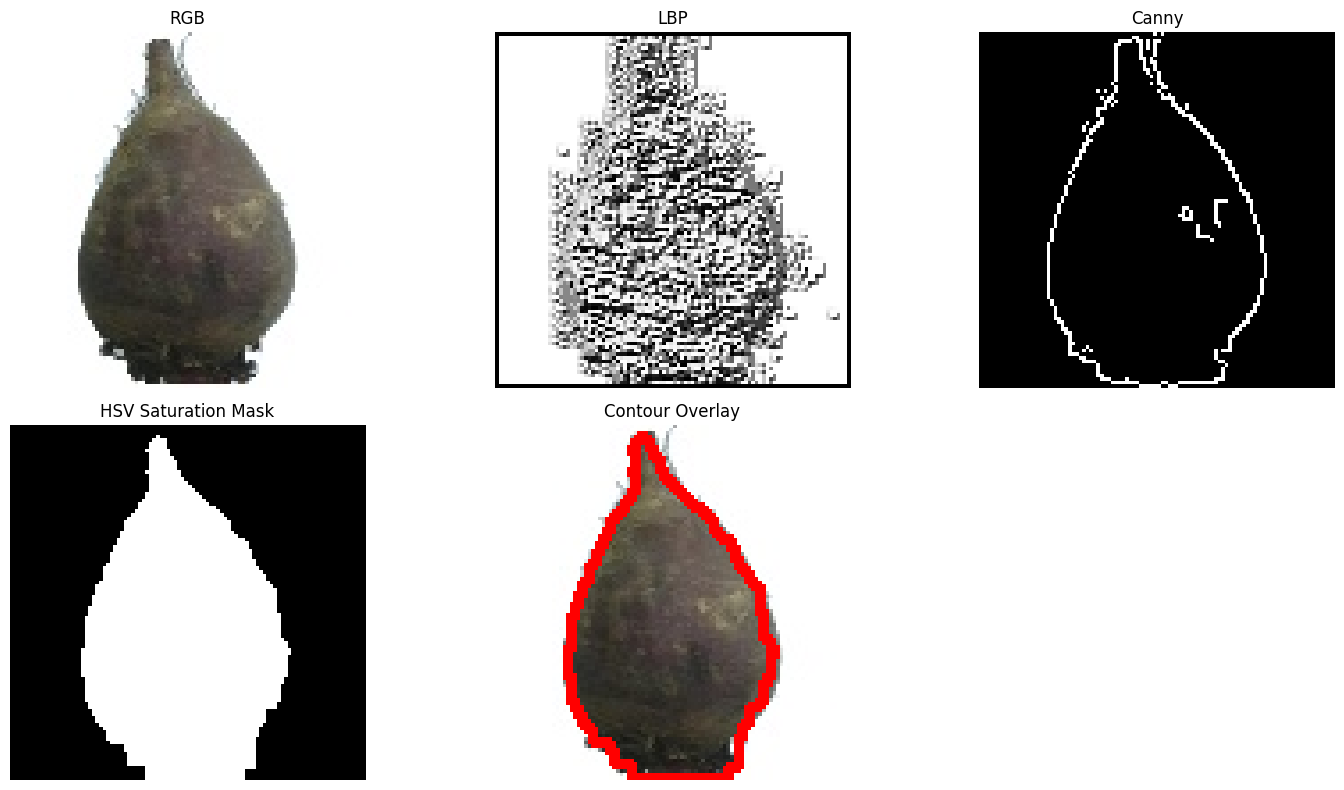

Linear features for: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training/Beetroot 1/0_100.jpg


,H_mean,H_std,S_mean,S_std,V_mean,V_std,Area_ratio,Aspect_ratio,Perimeter_norm,Circularity,Hu1,Hu2
0,43.261215,32.991905,0.19472,0.052269,0.303682,0.103948,0.3916,0.626263,311.421353,0.507406,0.739944,2.237849


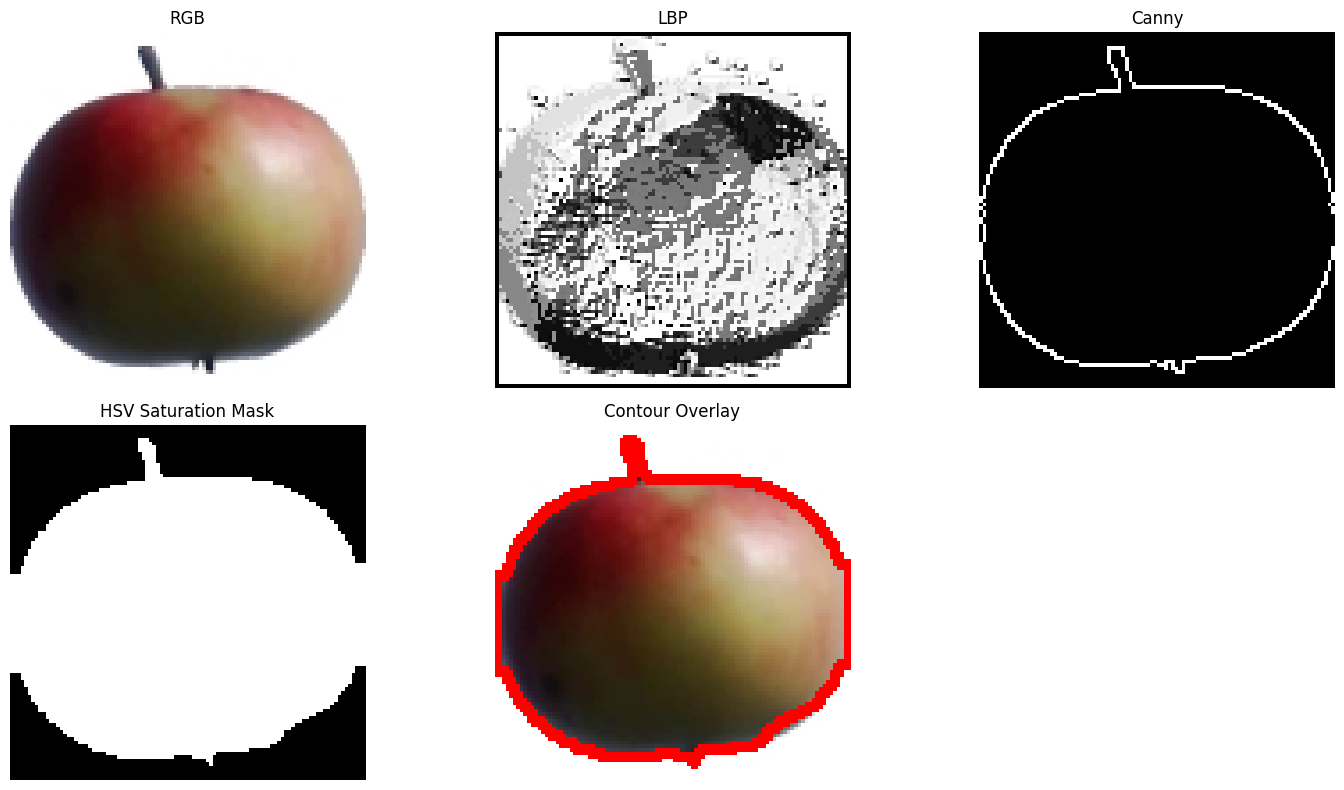

Linear features for: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training/Apple 11/r0_0_100.jpg


,H_mean,H_std,S_mean,S_std,V_mean,V_std,Area_ratio,Aspect_ratio,Perimeter_norm,Circularity,Hu1,Hu2
0,91.155136,119.078209,0.516309,0.218809,0.43811,0.247156,0.66045,1.086957,336.835567,0.731499,0.785977,2.936177


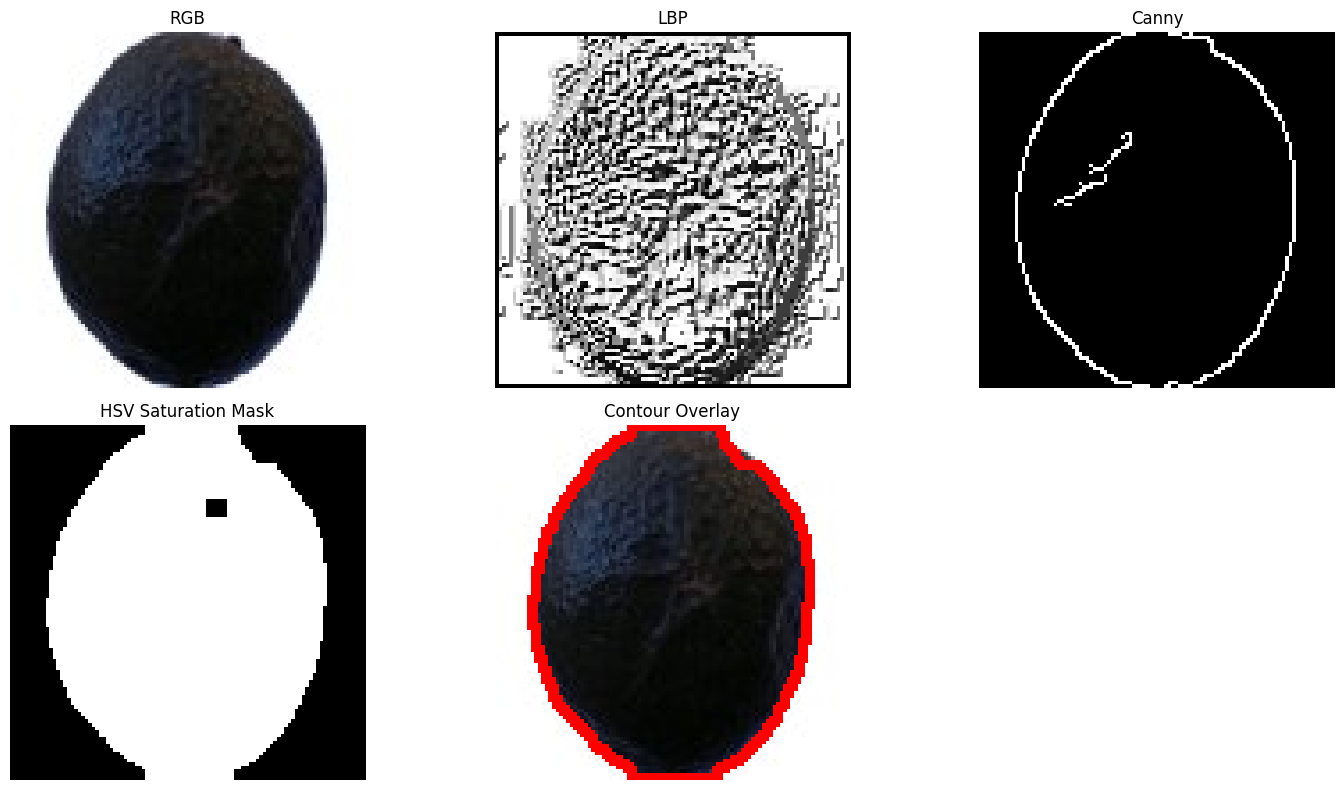

Linear features for: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training/Avocado Black 2/r0_0_100.jpg


,H_mean,H_std,S_mean,S_std,V_mean,V_std,Area_ratio,Aspect_ratio,Perimeter_norm,Circularity,Hu1,Hu2
0,167.300415,74.435959,0.318889,0.155447,0.126522,0.095569,0.6146,0.79,311.906634,0.793877,0.784935,2.80885


(array([1.6730042e+02, 7.4435959e+01, 3.1888941e-01, 1.5544736e-01,
        1.2652245e-01, 9.5568925e-02], dtype=float32),
 array([  0.6146    ,   0.79      , 311.90663433,   0.79387695,
          0.7849347 ,   2.8088501 ]))

In [72]:
sample_path = os.path.join(training, "Beetroot 1", "0_100.jpg")
visualize_sample(sample_path)
print_linear_features(sample_path)
sample_path = os.path.join(training, "Apple 11", "r0_0_100.jpg")
visualize_sample(sample_path)
print_linear_features(sample_path)
sample_path = os.path.join(training, "Avocado Black 2", "r0_0_100.jpg")
visualize_sample(sample_path)
print_linear_features(sample_path)